In [2]:
# Import for the Assigment3
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import math
import pickle
import copy as copy
from numpy import random
from tqdm import tqdm

In [3]:
# Global Variable
training_file = "data_batch_1"
validation_file = "data_batch_2"
test_file = "test_batch"
data_folder = "../../save/assigment1-save/Datasets/cifar-10-batches-py/"
N = 10000
K = 10
d = 3072
m = 50

In [4]:
def hot_one(y):
    Y = []
    for yi in y:
        yihot = [0] * K
        yihot[yi] = 1
        Y.append(yihot)
    return np.array(Y)
    
    
#Functions that load data from file.
def load_batch(file_name):

    with open(file_name, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    y = np.hstack(dict[b'labels'])
    X = dict[b'data'].astype(float).T / 255.0
    Y = hot_one(y).T
    return X,Y,y

In [5]:
def normalizeData(X):
    m = np.mean(X,1)
    std = np.std(X,1)
    #X = (X.T - m).T
    return X, m , std

def plot_curve(lostTrain, lostVal):
    rr = range(len(lostVal))
    plt.plot(rr, lostVal,'green')
    plt.plot(rr, lostTrain,'blue')
    plt.title("loss during the training for eta = " + str(eta) + " lambda = " + str(lamb))
    green_patch = mpatches.Patch(color='blue', label="Training loss")
    blue_patch = mpatches.Patch(color='green', label="Validation loss")
    plt.legend(handles=[green_patch, blue_patch])
    plt.savefig(str(lamb) + '_'+ str(eta) + '.png')
    plt.show()
    
def initializeWb_Hu(dim_list):
    mu = 0
    W = []
    b = []
    for i in range(len(dim_list) - 1):
        W.append(np.random.normal(mu, np.sqrt(2.0 / dim_list[i + 1]), (dim_list[i + 1], dim_list[i])))
        b.append(np.random.normal(mu, np.sqrt(2.0 / dim_list[i + 1]), (dim_list[i + 1], 1)))
    return W, b
def initializeWb_Random(dim_list):
    mu = 0
    W = []
    b = []
    for i in range(len(dim_list) - 1):
        W.append(np.random.normal(mu, 0.1, (dim_list[i + 1], dim_list[i])))
        b.append(np.random.normal(mu, 0.1, (dim_list[i + 1], 1)))
    return W, b

In [8]:
#Load of every datasete

X_train, Y_train, y_train = load_batch(data_folder + training_file)
X_test, Y_test, y_test = load_batch(data_folder + test_file)
X_val, Y_val, y_val = load_batch(data_folder + validation_file)
X_train, m , std = normalizeData(X_train)
X_train = (X_train.T - m).T
X_test = (X_test.T - m).T
X_val = (X_val.T - m).T

In [9]:
def batch_norm(s_l, mu_l, nu_l, eps):
    # s_l = d_l * N
    assert(s_l.shape[0] == (mu_l.shape[0]) and s_l.shape[0] == (nu_l.shape[0]))
    s_hat_l = copy.deepcopy(s_l)
    for i in range(s_l.shape[0]):
        for j in range(s_l.shape[1]):
            s_hat_l[i][j] = (s_hat_l[i][j] - mu_l[i]) / ((nu_l[i] + eps) ** 0.5)
    return s_hat_l    
    #return np.multiply((s_l - mu_l),((nu_l) ** 1.0))

def evaluate_Classifier_batch(X_0, W, b, eps, mean_layer=None, std_layer=None):
    # X_0 = D x N , W_0 = D_1 x D_0....
    flag_mean_std_to_compute = False
    if (mean_layer == None or std_layer == None):
        flag_mean_std_to_compute = True
        mean_layer = []
        std_layer = []
    
    ss = []
    x = [X_0]
    x_l = x[0]
    for l in range(0,len(W) - 1):
        assert(W[l].shape[1] == x[l].shape[0])
        assert(W[l].shape[0] == b[l].shape[0])

        s_l = np.dot(W[l], x_l) + b[l]
        #print(s_l.shape)
        ss.append(s_l)
        if (flag_mean_std_to_compute):
            mean_layer.append(np.mean(s_l, axis=1, keepdims=True))
            std_layer.append(np.std(s_l, axis=1, keepdims=True) ** 2)
        s_hat_l = batch_norm(s_l, mean_layer[l], std_layer[l], eps)
        x_l = np.maximum(s_hat_l, 0)
        x.append(x_l)
    
    ## final layer
    s = np.dot(W[-1], x[-1]) + b[-1]
    #D_final x N
    
    aux = np.exp(s)
    summ = np.sum(aux, axis=0) #axis=0 sum by colum so we got 1000 therm to normalize
    p = aux / summ
    return p, x, ss, mean_layer, std_layer

def compute_Cost_batch(X, Y, W, b, lamb, eps, mean_layer=None, std_layer=None, p=None):
    J = 0
    if (np.all(p == None)):
        p, _, _, _, _ = evaluate_Classifier_batch(X, W, b, eps, mean_layer, std_layer)
    for l in range(X.shape[1]):
        J += - np.log(np.sum(p[:,l] * Y[:,l]))
    J /= X.shape[1]
    
    for w in W:
        J += lamb * np.sum(w ** 2)
        
    return J
        

In [10]:
def compute_Gradients_Num_batch(X, Y, p, W, b, lamb, h, eps, mean_layer=None, std_layer=None):
    print(W[0].shape)
    grad_W = []
    grad_b = []
    N = X.shape[1]
    # Initialization of grad
    for i in range(len(W)):
        grad_W.append(np.zeros((W[i].shape[0],W[i].shape[1])))
        grad_b.append(np.zeros((b[i].shape[0],b[i].shape[1])))

    c =  compute_Cost_batch(X, Y, W, b, lamb, eps, mean_layer, std_layer, p)
    
    for index in range(len(W)):
        for i in range(W[index].shape[0]):
            for j in range(W[index].shape[1]):
                W[index][i][j] += h
                c2 = compute_Cost_batch(X, Y, W, b, lamb, eps, mean_layer, std_layer)
                W[index][i][j] -= 2 * h
                c1 = compute_Cost_batch(X, Y, W, b, lamb, eps, mean_layer, std_layer)
                grad_W[index][i][j] = (c2 - c1) / (2 * h)
                W[index][i][j] += h

        for i in range(len(b[index])):
            b[index][i] += h
            c2 = compute_Cost_batch(X, Y, W, b, lamb, eps, mean_layer, std_layer)
            b[index][i] -= 2 * h
            c1 = compute_Cost_batch(X, Y, W, b, lamb, eps, mean_layer, std_layer)
            b[index][i] += h
            grad_b[index][i] = (c2 - c1) / (2 * h)
    return np.array(grad_W), np.array(grad_b)

In [47]:
def compute_Gradients_batch(X, Y, p, x, s, W, b, lamb, mean_layer, std_layer, eps):
    grad_W = []
    grad_b = []
    N = X.shape[1]
    #print(N)
    # Initialization of grad
    for i in range(len(W)):
        grad_W.append(np.zeros((W[i].shape[0],W[i].shape[1])))
        grad_b.append(np.zeros((b[i].shape[0],b[i].shape[1])))
    
    g = - (Y.T - p.T)
    # g = N x K
    # x = K_last_last x N
    
    gx = np.dot(g.T, x[-1].T)
    # gx = K x K_-1
    #print('g0 shape', g.shape)
    grad_b[-1] += np.mean(g.T, axis=1, keepdims=True)
    grad_W[-1] += gx
    grad_W[-1] /= N
    grad_W[-1] += 2 * lamb * W[-1]
    
    #First update of g
    # g = N x K
    g = np.dot(g,W[-1])
    g1 = np.where(x[-1] > 0, 1, 0) 
    g = np.multiply(g.T, g1)
    #g = K_-1 x N
    
    for l in range(len(W) - 2, -1, -1):
        X_l_centered = s[l]
        
        # K_-1 * N
        V = (std_layer[l]) ** (-0.5)
        #print(V.shape) #K x 1
        #print(g.shape) #K x N
        #print(X_l_centered.shape) # K x N
        g = BatchNormBackPass2(g, X_l_centered, mean_layer[l], V)
        
        g = g.T
        grad_b[l] = np.mean(g.T, axis=1, keepdims=True)
        # gx = K_-1 x K_-2
        ##print(g)
        gx = np.dot(g.T, x[l].T)
        grad_W[l] = gx
        grad_W[l] /= N
        grad_W[l] += 2 * lamb * W[l]
        
        if(l > 0):
            g = np.dot(g, W[l])
            g1 = np.where(x[l] > 0, 1, 0)
            g = np.multiply(g.T, g1)
             
    return grad_W, grad_b

def BatchNormBackPass(g, s, mu, V):
    m, n = g.shape
    g_out = np.zeros(g.shape)
    gradJ_std = np.zeros((m, 1))
    gradJ_mean = np.zeros((m, 1))
    for i in range(n):
        s_i = np.reshape(np.array(s[:,i]),(s.shape[0], 1))
        g_i = np.reshape(np.array(g[:,i]), (m, 1))      
        gradJ_std -= np.dot(diag(s_i - mu), g_i * (V ** 3))
        gradJ_mean -= g_i * V
    for i in range(n):
        s_i = np.reshape(np.array(s[:,i]),(s.shape[0], 1))
        g_i = np.reshape(np.array(g[:,i]), (m, 1))
        g_out[:,i] = (g_i * V + np.dot(diag(s_i- mu), gradJ_std) / n + gradJ_mean / n)[:,0]
    g_out =  g * (V) + ((s - mu) * gradJ_std) / N + (gradJ_mean / N)
    return g_out

    
def BatchNormBackPass2(g, s, mu, V):
    #gradJ_std = - (std_layer[l] ** (-1.5)) * np.sum(g * X_i_centered, axis=1, keepdims=True)
    #gradJ_mean = - (std_layer[l] ** (-0.5)) * np.sum(g, axis=1, keepdims=True)
    m, n = g.shape
    
    g_out = np.zeros(g.shape)
    gradJ_std = np.zeros((m, 1))
    gradJ_mean = np.zeros((m, 1))
   
    X_i_centered = s - mu # m x N
    
    gradJ_std =  (V ** 3) * - np.sum(g  * X_i_centered, axis=1, keepdims=True)
    gradJ_mean = - np.sum(g * V, axis=1, keepdims=True)
    g_out =  g * (V) +  (X_i_centered * gradJ_std) / N + (gradJ_mean / N)
    return g_out

def diag(vec):
    diagonal = np.zeros((vec.shape[0],vec.shape[0]))
    for i in range(vec.shape[0]):
        diagonal[i][i] = vec[i]
    return diagonal

In [51]:
K = 10
d = 100
n = 100
dim_list = [d, 20, 20, 10, K]
h = 1e-6
lamb = 0
rho = 0.9

eps = 10e-06
X = X_train[:d,:n]
Y = Y_train[:,:n]
W, b = initializeWb_Random(dim_list)#initializeWb_Random(dim_list)

p, x, s_hat, mean_layer, std_layer  = evaluate_Classifier_batch(X, W, b, eps)
J = compute_Cost_batch(X, Y, W, b, lamb, eps, mean_layer, std_layer, p)
print(J)

#print(np.sum(p, 1))

2.328856285487964


In [52]:
grad_W11, grad_b11  = compute_Gradients_Num_batch(X, Y, p, W, b, lamb, h, eps,  mean_layer, std_layer)
grad_W1, grad_b1 = compute_Gradients_batch(X, Y, p, x, s_hat, W, b, lamb, mean_layer, std_layer, eps)

for i in range(len(W)):
    print("Norm for W & b for the " + str(i) + "layer")
    assert(grad_W1[i].shape ==grad_W11[i].shape)
    print(np.linalg.norm(grad_W1[i] - grad_W11[i],ord=1) / max(h ,np.linalg.norm(grad_W1[i] ,ord=1) + np.linalg.norm(grad_W11[i] ,ord=1)))
    print(np.linalg.norm(grad_b1[i] - grad_b11[i],ord=1) / max(h ,np.linalg.norm(grad_b1[i] ,ord=1) + np.linalg.norm(grad_b11[i] ,ord=1)))

(20, 100)
Norm for W & b for the 0layer
0.007358882587647598
0.010511630350862078
Norm for W & b for the 1layer
0.0035735929621261366
0.008367704771781555
Norm for W & b for the 2layer
0.0030200376904453512
0.004966653777739126
Norm for W & b for the 3layer
6.663013290222713e-09
8.019776726139789e-09


In [15]:

def compute_Accuracy_batch(X, y, W, b, eps, mean_layer=None, std_layer=None, p=None):
    if(np.all(p == None)):
        p, _, _, _, _= evaluate_Classifier_batch(X, W, b, eps, mean_layer, std_layer) 
    
    pred = np.argmax(p,axis=0)
    acc = 0.0
    for i in range(len(pred)):
        if(pred[i] == y[i]):
            acc += 1
    return acc / len(pred)

In [71]:
def fit(X, Y, y, X_val, Y_val, y_val, lamb, n_batch, rho, eta , n_epochs, dim_list, W, b, eps, norm_coef):
    m = X.shape[0]
    N = X.shape[1]
    lostTrain = []
    lostVal = []
    W_momentum = []
    b_momentum = []
    for i in range(len(W)):
        W_momentum.append(np.zeros((W[i].shape[0],W[i].shape[1])))
        b_momentum.append(np.zeros((b[i].shape[0],b[i].shape[1])))
    mean_layer=None
    std_layer=None
    for step in range(n_epochs):
        
        
        for j in range(int(N / n_batch)):

            start = j * n_batch
            end = (j + 1) * n_batch
            X_batch = X[:,start:end]
            Y_batch = Y[:,start:end]

            p, x, s_hat, mean_layer_out, std_layer_out = evaluate_Classifier_batch(X_batch, W, b, eps)

            if(mean_layer == None or std_layer == None):
                mean_layer = copy.deepcopy(mean_layer_out)
                std_layer = copy.deepcopy(std_layer_out)
            
            grad_W, grad_b = compute_Gradients_batch(X_batch, Y_batch, p, x, s_hat, W, b, lamb, mean_layer_out, std_layer_out, eps)

            for i in range(len(W) - 1):
                mean_layer[i] = norm_coef *  mean_layer[i] + (1 - norm_coef) * mean_layer_out[i]
                std_layer[i] = norm_coef *  std_layer[i] + (1 - norm_coef) * std_layer_out[i]
            for i in range(len(W)):
                W_momentum[i] = W_momentum[i] * rho +  eta * grad_W[i]
                b_momentum[i] = b_momentum[i] * rho +  eta * grad_b[i]
                W[i] -= W_momentum[i]
                b[i] -= b_momentum[i]
        print("At the step :", step)
        print("Accurency on the train = "  + str(compute_Accuracy_batch(X_train, y_train, W, b, eps, mean_layer, std_layer)))
        print("Accurency on the validation = "  + str(compute_Accuracy_batch(X_val, y_val, W, b, eps, mean_layer, std_layer)))
        eta *= 0.95
        lostTrain.append(compute_Cost_batch(X, Y, W, b, lamb, eps, mean_layer, std_layer))
        lostVal.append(compute_Cost_batch(X_val, Y_val, W, b, lamb,eps, mean_layer, std_layer))
    return W, b, lostTrain, lostVal, mean_layer, std_layer

(3072, 1000)
At the step : 0
Accurency on the train = 0.2967
Accurency on the validation = 0.282
At the step : 1
Accurency on the train = 0.3297
Accurency on the validation = 0.312
At the step : 2
Accurency on the train = 0.3512
Accurency on the validation = 0.338
At the step : 3
Accurency on the train = 0.362
Accurency on the validation = 0.34
At the step : 4
Accurency on the train = 0.3673
Accurency on the validation = 0.348
At the step : 5
Accurency on the train = 0.3739
Accurency on the validation = 0.356
At the step : 6
Accurency on the train = 0.3773
Accurency on the validation = 0.36
At the step : 7
Accurency on the train = 0.3786
Accurency on the validation = 0.354
At the step : 8
Accurency on the train = 0.3803
Accurency on the validation = 0.354
At the step : 9
Accurency on the train = 0.3825
Accurency on the validation = 0.356
At the step : 10
Accurency on the train = 0.3862
Accurency on the validation = 0.363
At the step : 11
Accurency on the train = 0.3888
Accurency on the

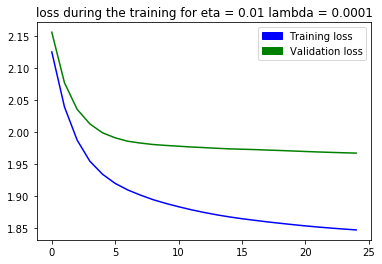

In [59]:
N = 10000
N_bis = 9000
K = 10
d = 3072
lamb = 0.0001
alpha = 0.95
dim_list = [d, 50, 30, K]
X = X_train[:,:N_bis]
Y = Y_train[:,:N_bis]
y = y_train[:N_bis]

X_val = X_train[:,N_bis:]
Y_val = Y_train[:,N_bis:]
y_val = y_train[N_bis:]


n_batch= 100
eta= 0.01
n_epochs= 25
rho = 0.9
W_init, b_init = initializeWb_Random(dim_list)
eps = 10e-06
W, b, lostTrain, lostVal, mean_layer, std_layer = fit(X, Y, y, X_val, Y_val, y_val,  lamb, n_batch, rho, eta, n_epochs, dim_list, W_init, b_init, eps, alpha)

print("Accurency on the test = "  + str(compute_Accuracy_batch(X_test, y_test, W, b, eps, mean_layer, std_layer)))
plot_curve(lostTrain, lostVal)

(50, 3072)
(30, 50)
(10, 30)
Accurency on the test = 0.4707


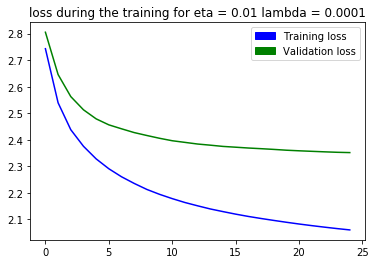

In [58]:
for i in range(len(W)):
    print(W[i].shape)
    
print("Accurency on the test = "  + str(compute_Accuracy_batch(X_train, y_train, W, b, eps, mean_layer, std_layer)))
plot_curve(lostTrain, lostVal)

### Grid search

In [63]:
eta_start = 0.01
eta_end = 0.1
eta_number = 5
eta_step = (eta_end - eta_start) / eta_number
grid_eta = np.arange(eta_start, eta_end, eta_step)


lamb_start = 0.00001
lamb_end = 0.0001
lamb_number = 5
lamb_step = (lamb_end - lamb_start) / lamb_number
grid_lamb = np.arange(lamb_start, lamb_end, lamb_step)


N = 10000
N_bis = 9000
K = 10
d = 3072

m = 50
X = X_train[:,:N_bis]
Y = Y_train[:,:N_bis]
y = y_train[:N_bis]


X_val = X_train[:,N_bis:]
Y_val = Y_train[:,N_bis:]
y_val = y_train[N_bis:]
n_batch= 100
n_epochs= 5
rho = 0.9

best_score = 0.0
best_lamb = 0
best_eta = 0
result = []
for lamb in grid_lamb:
    for eta in grid_eta:
        W, b, lostTrain, lostVal, mean_layer, std_layer = fit(X, Y, y, X_val, Y_val, y_val,  lamb, n_batch, rho, eta, n_epochs, dim_list, W_init, b_init, eps, alpha)
        acc = compute_Accuracy_batch(X_val, y_val, W, b, eps, mean_layer, std_layer)
        result.append((acc,lamb,eta))



In [76]:
best = sorted(result)[-1]
acc, lamb, eta = best
print(best)

(0.406, 4.600000000000001e-05, 0.01)


At the step : 0
Accurency on the train = 0.2307
Accurency on the validation = 0.225
At the step : 1
Accurency on the train = 0.3098
Accurency on the validation = 0.279
At the step : 2
Accurency on the train = 0.3395
Accurency on the validation = 0.314
At the step : 3
Accurency on the train = 0.3573
Accurency on the validation = 0.318
At the step : 4
Accurency on the train = 0.3739
Accurency on the validation = 0.347
At the step : 5
Accurency on the train = 0.3848
Accurency on the validation = 0.36
At the step : 6
Accurency on the train = 0.3922
Accurency on the validation = 0.358
At the step : 7
Accurency on the train = 0.4001
Accurency on the validation = 0.358
At the step : 8
Accurency on the train = 0.4057
Accurency on the validation = 0.355
At the step : 9
Accurency on the train = 0.4129
Accurency on the validation = 0.355
At the step : 10
Accurency on the train = 0.4192
Accurency on the validation = 0.363
At the step : 11
Accurency on the train = 0.4246
Accurency on the validation

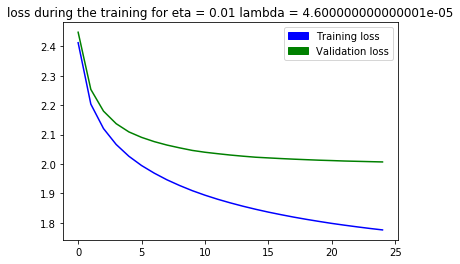

In [74]:
n_epochs= 25
W_init, b_init = initializeWb_Hu(dim_list)
eps = 10e-06
W, b, lostTrain, lostVal, mean_layer, std_layer = fit(X, Y, y, X_val, Y_val, y_val,  lamb, n_batch, rho, eta, n_epochs, dim_list, W_init, b_init, eps, alpha)

print("Accurency on the test = "  + str(compute_Accuracy_batch(X_test, y_test, W, b, eps, mean_layer, std_layer)))
plot_curve(lostTrain, lostVal)

### 2-layers 

In [87]:
N = 10000
N_bis = 9000
K = 10
d = 3072
lamb = 0.0001
alpha = 0.95

X = X_train[:,:N_bis]
Y = Y_train[:,:N_bis]
y = y_train[:N_bis]

X_val = X_train[:,N_bis:]
Y_val = Y_train[:,N_bis:]
y_val = y_train[N_bis:]

n_batch= 100
eta= 0.01
n_epochs= 25
rho = 0.9
eps = 10e-06
dim_list = [d, 50, K]
W_init, b_init = initializeWb_Hu(dim_list)

At the step : 0
Accurency on the train = 0.219
Accurency on the validation = 0.204
At the step : 1
Accurency on the train = 0.2704
Accurency on the validation = 0.256
At the step : 2
Accurency on the train = 0.3025
Accurency on the validation = 0.276
At the step : 3
Accurency on the train = 0.3235
Accurency on the validation = 0.295
At the step : 4
Accurency on the train = 0.337
Accurency on the validation = 0.302
At the step : 5
Accurency on the train = 0.3503
Accurency on the validation = 0.317
At the step : 6
Accurency on the train = 0.3609
Accurency on the validation = 0.321
At the step : 7
Accurency on the train = 0.3706
Accurency on the validation = 0.325
At the step : 8
Accurency on the train = 0.3782
Accurency on the validation = 0.329
At the step : 9
Accurency on the train = 0.3844
Accurency on the validation = 0.335
At the step : 10
Accurency on the train = 0.3901
Accurency on the validation = 0.337
At the step : 11
Accurency on the train = 0.3943
Accurency on the validation 

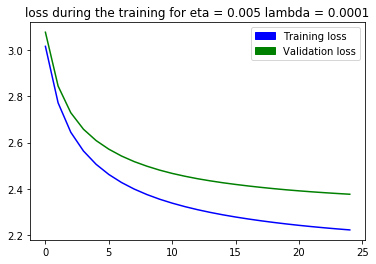

In [88]:
eta= 0.005
W, b, lostTrain, lostVal, mean_layer, std_layer = fit(X, Y, y, X_val, Y_val, y_val,  lamb, n_batch, rho, eta, n_epochs, dim_list, W_init, b_init, eps, alpha)

print("Accurency on the test = "  + str(compute_Accuracy_batch(X_test, y_test, W, b, eps, mean_layer, std_layer)))
plot_curve(lostTrain, lostVal)

At the step : 0
Accurency on the train = 0.4309
Accurency on the validation = 0.373
At the step : 1
Accurency on the train = 0.4409
Accurency on the validation = 0.384
At the step : 2
Accurency on the train = 0.4493
Accurency on the validation = 0.381
At the step : 3
Accurency on the train = 0.4566
Accurency on the validation = 0.391
At the step : 4
Accurency on the train = 0.463
Accurency on the validation = 0.39
At the step : 5
Accurency on the train = 0.4671
Accurency on the validation = 0.395
At the step : 6
Accurency on the train = 0.4711
Accurency on the validation = 0.397
At the step : 7
Accurency on the train = 0.4733
Accurency on the validation = 0.397
At the step : 8
Accurency on the train = 0.4788
Accurency on the validation = 0.401
At the step : 9
Accurency on the train = 0.4809
Accurency on the validation = 0.399
At the step : 10
Accurency on the train = 0.4845
Accurency on the validation = 0.401
At the step : 11
Accurency on the train = 0.4889
Accurency on the validation 

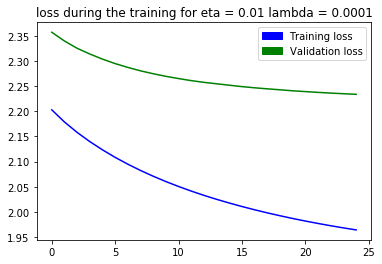

In [89]:
eta= 0.01
W, b, lostTrain, lostVal, mean_layer, std_layer = fit(X, Y, y, X_val, Y_val, y_val,  lamb, n_batch, rho, eta, n_epochs, dim_list, W_init, b_init, eps, alpha)

print("Accurency on the test = "  + str(compute_Accuracy_batch(X_test, y_test, W, b, eps, mean_layer, std_layer)))
plot_curve(lostTrain, lostVal)

At the step : 0
Accurency on the train = 0.5104
Accurency on the validation = 0.406
At the step : 1
Accurency on the train = 0.5196
Accurency on the validation = 0.41
At the step : 2
Accurency on the train = 0.5283
Accurency on the validation = 0.415
At the step : 3
Accurency on the train = 0.5352
Accurency on the validation = 0.419
At the step : 4
Accurency on the train = 0.5421
Accurency on the validation = 0.419
At the step : 5
Accurency on the train = 0.5481
Accurency on the validation = 0.416
At the step : 6
Accurency on the train = 0.5506
Accurency on the validation = 0.415
At the step : 7
Accurency on the train = 0.5568
Accurency on the validation = 0.415
At the step : 8
Accurency on the train = 0.5614
Accurency on the validation = 0.418
At the step : 9
Accurency on the train = 0.5657
Accurency on the validation = 0.418
At the step : 10
Accurency on the train = 0.5716
Accurency on the validation = 0.417
At the step : 11
Accurency on the train = 0.5764
Accurency on the validation

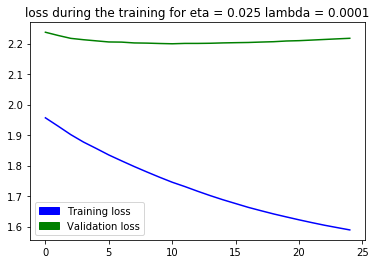

In [90]:
eta= 0.025
W, b, lostTrain, lostVal, mean_layer, std_layer = fit(X, Y, y, X_val, Y_val, y_val,  lamb, n_batch, rho, eta, n_epochs, dim_list, W_init, b_init, eps, alpha)

print("Accurency on the test = "  + str(compute_Accuracy_batch(X_test, y_test, W, b, eps, mean_layer, std_layer)))
plot_curve(lostTrain, lostVal)